In [1]:
from copy import deepcopy
import math
import sys

import matplotlib.pylab as plt
import numpy as np

%reload_ext autoreload
%autoreload 2

#%matplotlib inline
%matplotlib notebook

sys.path.append('../crazyflie-audio/python/')

In [2]:
import pyroomacoustics as pra
from bin_selection import select_frequencies
from signals import generate_signal, amplify_signal
from scipy.spatial.transform import Rotation

def rotate_mics(mics, orientation_deg=0):
    """
    :param mics: mic positions (n_mics, 2)
    :return mics_rotated: (n_mics, 2)
    """
    rot = Rotation.from_euler('z', orientation_deg, degrees=True)
    R = rot.as_matrix() # 3x3
    mics_aug = np.c_[mics, np.ones(mics.shape[0])].T # 3 x 4
    mics_rotated = R.dot(mics_aug)[:2, :] # 2 x 4
    return mics_rotated.T

def plot_spectrum(spectrum, degree=0):
    plt.figure()
    if spectrum.shape[0] == 1:
        plt.plot(angles, np.log10(spectrum[0]))
    else:
        plt.pcolormesh(angles, frequencies, np.log10(spectrum))
    plt.axvline(degree, color='red')
    plt.xlabel('angle [deg]')
    plt.ylabel('frequency [Hz]')
    
def select_here():
    if signal_type=="random":
        indices = select_frequencies(n_buffer, Fs, min_freq=200, max_freq=7000)
    elif signal_type=="mono":
        indices = select_frequencies(n_buffer, Fs, min_freq=frequency_hz, max_freq=frequency_hz)
        indices = np.unique(indices)
    print(f'selecting {len(indices)} bins')
    return indices

# 1. Geometrical setup

<IPython.core.display.Javascript object>


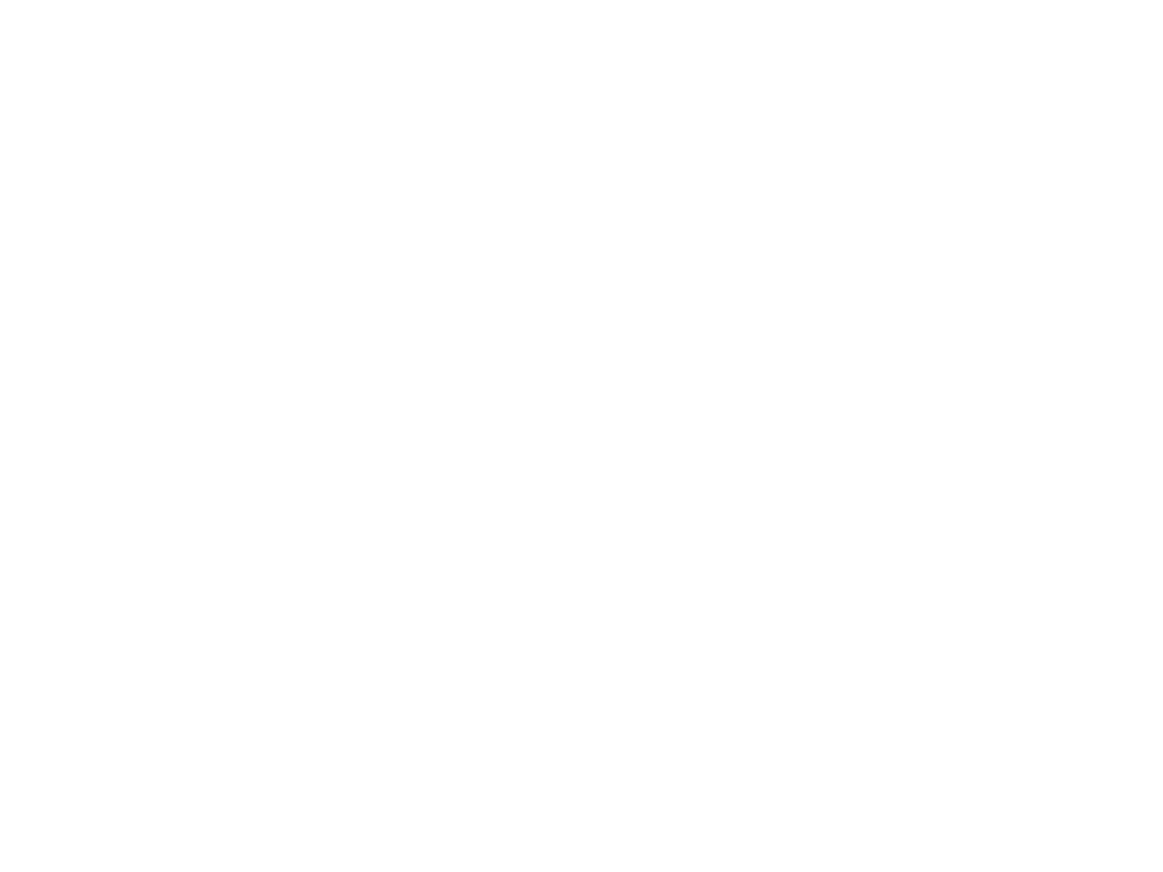

<IPython.core.display.Javascript object>


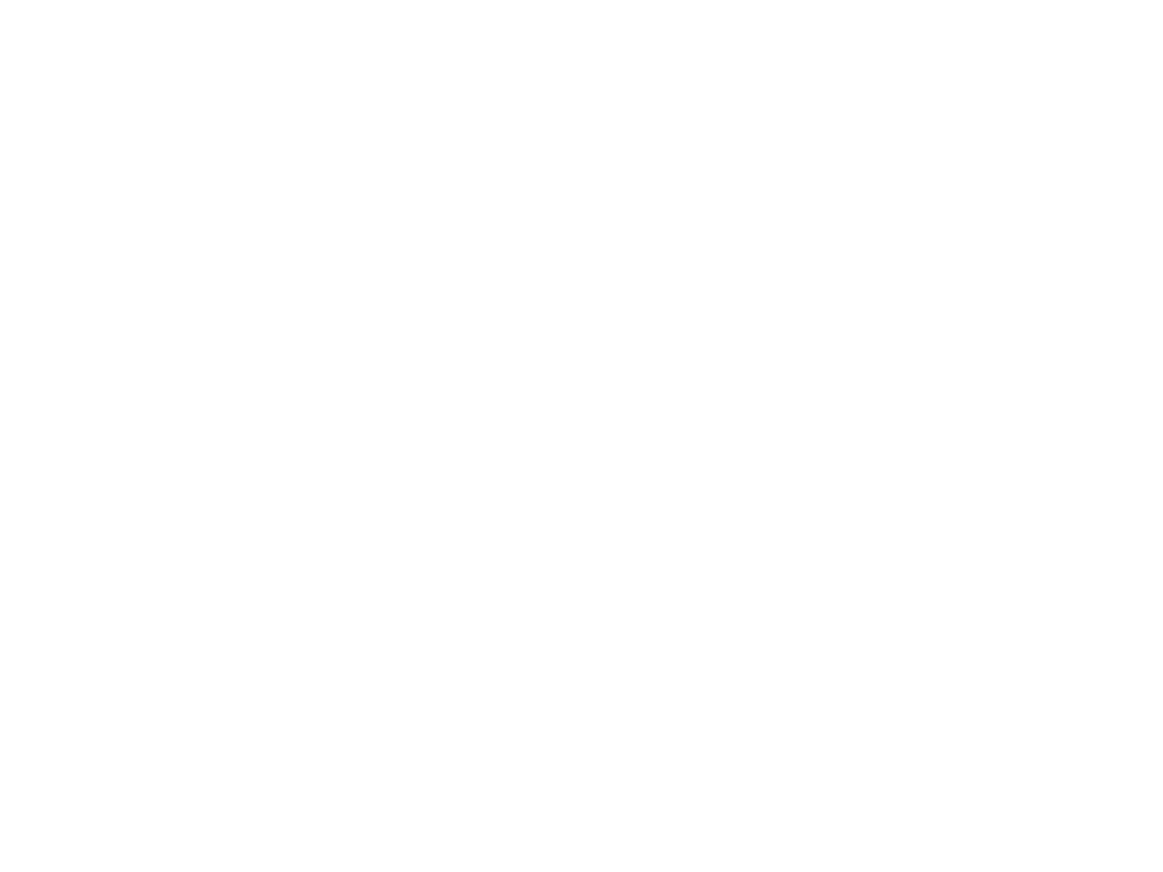

(-0.005000000000000001,
 0.10500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

In [3]:
from mic_array import get_square_array, get_uniform_array

baseline = 0.1  # meters, square side of mic array
gt_distance = 10  # meters, distance of source
add_noise_mics_positions = 0 
add_noise_times = 0

#mics_drone = get_square_array(baseline=baseline, delta=0) # 4 x 2
mics_drone = get_uniform_array(2, baseline=baseline) # 4 x 2
if add_noise_mics_positions > 0:
    mics_drone += np.random.normal(scale=add_noise_mics_positions, size=mics_drone.shape)

gt_angle_deg = 25
gt_angle_rad = gt_angle_deg * np.pi / 180.0
source = gt_distance * np.array([np.cos(gt_angle_rad), np.sin(gt_angle_rad)])

plt.figure()
plt.scatter(*mics_drone.T)
plt.scatter(*source)
plt.axis('equal')

plt.figure()
plt.scatter(*mics_drone.T)
plt.axis('equal')

# 2. Audio source

In [4]:
Fs = 30000  # Hz, sampling frequency
duration = 100  # seconds, should be long enough to acocunt for delays and full movement
np.random.seed(1)
noise = 0.0
signal_type = "mono"; frequency_hz = 1000 
#signal_type = "random"; frequency_hz = None

source_signal = generate_signal(Fs, 
                                signal_type=signal_type, 
                                duration_sec=duration, 
                                frequency_hz=frequency_hz, 
                                noise=noise)
source_signal = amplify_signal(source_signal, target_dB=-10)

plt.plot(source_signal[:100])
plt.xlabel('time index [-]')
plt.ylabel('source [-]')

Text(0, 0.5, 'source [-]')

# simulate signals at mics

In [5]:
def generate_signals(source_signal, mics_rotated, time, noise=0, ax=None):
    room = pra.AnechoicRoom(fs=Fs, dim=2)
    room.add_source(source, signal=source_signal, name=f"source")

    beam_former = pra.Beamformer(mics_rotated, room.fs)
    room.add_microphone_array(beam_former)
    room.simulate()
    
    time_idx = int(round(time * Fs))
    print(time, Fs, time_idx)
    print('error:', time_idx / Fs, time, (time_idx / Fs) - time)
    
    signals = deepcopy(room.mic_array.signals)
    if noise > 0:
        signals += np.random.normal(scale=noise, size=signals.shape)
    print('shifted signals by', time_idx, signals.shape)
    
    if ax is not None:
        for i in range(signals.shape[0]):
            ax.plot(signals[i])
        ax.axvline(x=time_idx)
    return signals[:, time_idx:]

recording times in seconds: [0.0, 0.038636363636363635]


<IPython.core.display.Javascript object>


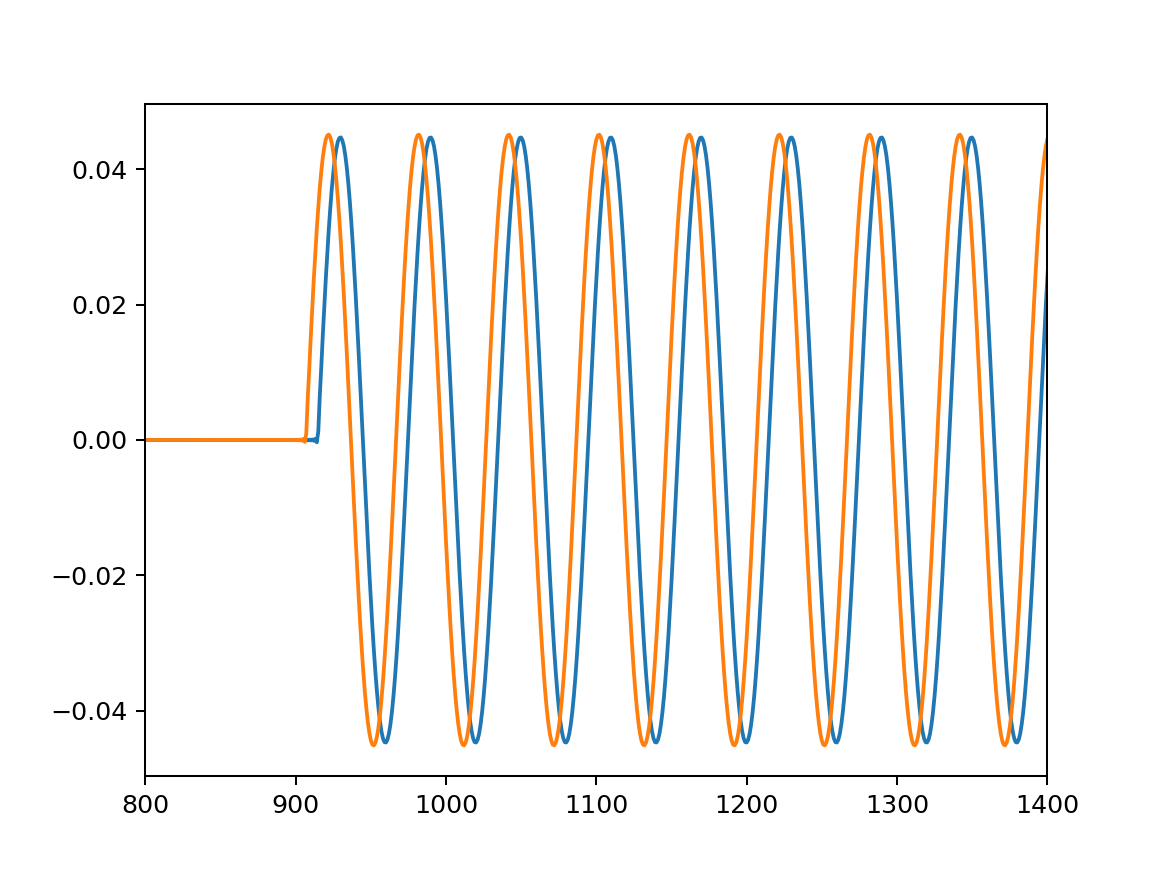

0.0 30000 0
error: 0.0 0.0 0.0
shifted signals by 0 (2, 3000956)


<IPython.core.display.Javascript object>


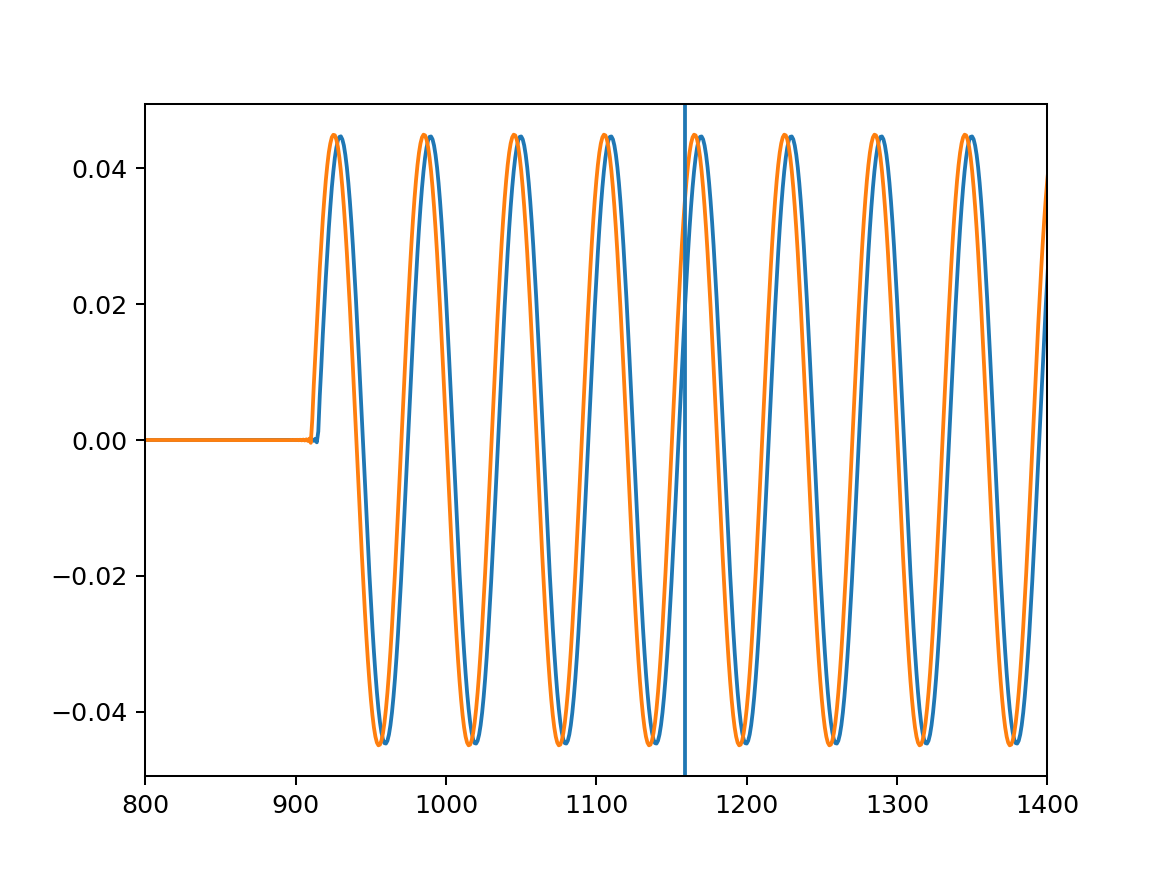

0.038636363636363635 30000 1159
error: 0.03863333333333333 0.038636363636363635 -3.0303030303033274e-06
shifted signals by 1159 (2, 3000956)


In [6]:
# create one long source signal
angular_velocity_deg = 2200 # deg/sec, velocity of drone
n_buffer = 500
time_index = 1000 # idx where signal is non-zero for all positions, found heuristically

#degrees = [0, 0]
#degrees = range(10)
#degrees = np.arange(0, 360, 45)
degrees = [0, 85] #, -40] 

if angular_velocity_deg != 0:
    times_list = [(d-degrees[0])/angular_velocity_deg for d in degrees] # seconds
else:
    times_list = [0] * len(degrees)
    
if add_noise_times > 0:
    times_list = [t + np.random.normal(scale=add_noise_times) for t in times_list]
print('recording times in seconds:', times_list)

assert duration > max(times_list)

np.random.seed(1)
mics_list = [rotate_mics(mics_drone, orientation_deg=degree) for degree in degrees]
# n_mics x n_times
#signals_list = [generate_signals(source_signal, mics.T, time) 
#                for mics, time in zip(mics_list, times_list)] 

signals_list = []

%matplotlib notebook
for mics, time in zip(mics_list, times_list):
    
    fig, ax = plt.subplots()
    signals_received =  generate_signals(source_signal, mics.T, time, noise=noise, ax=ax) 
    ax.set_xlim(800, 1400)
    
    signals_list.append(signals_received)

<IPython.core.display.Javascript object>


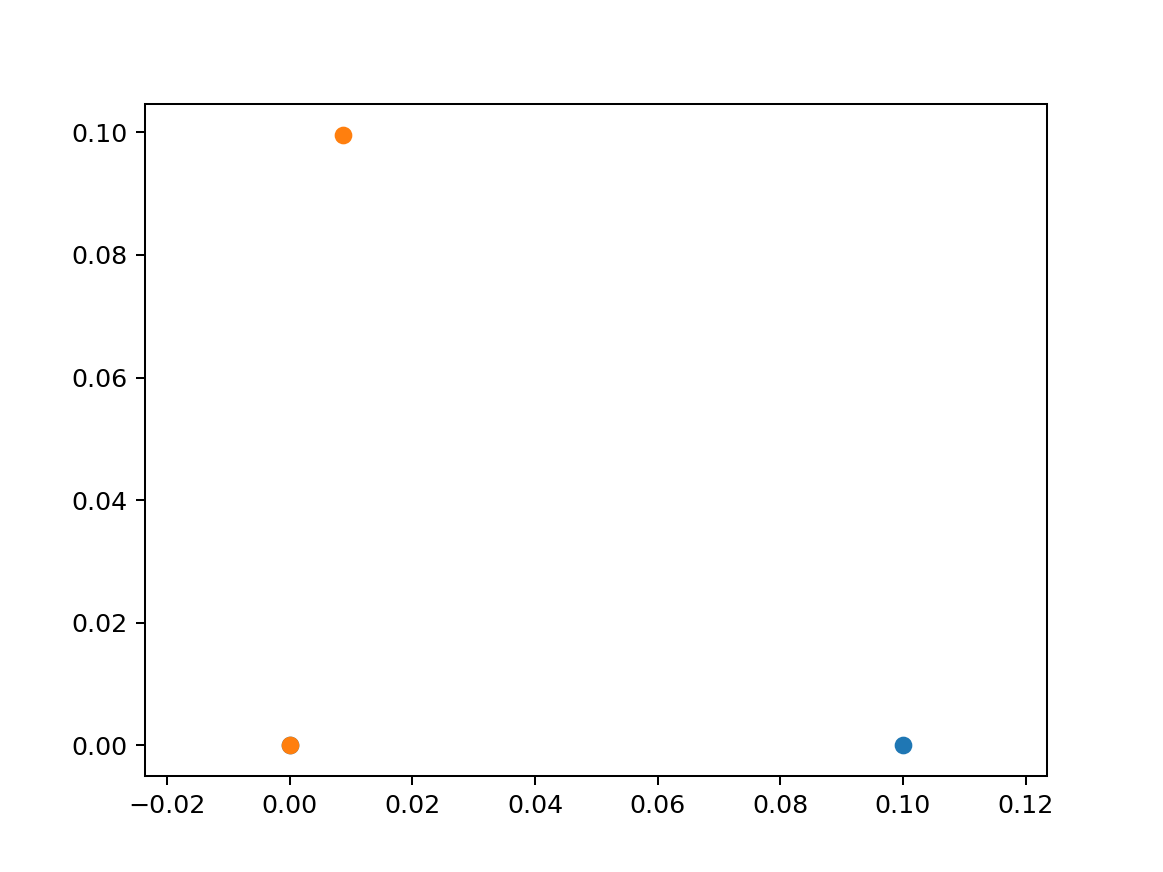

In [7]:
plt.figure()
[plt.scatter(*mics.T) for mics in mics_list]
plt.axis('equal')

buffers = [signals_this[:, time_index:time_index + n_buffer] for signals_this in signals_list] 

<IPython.core.display.Javascript object>


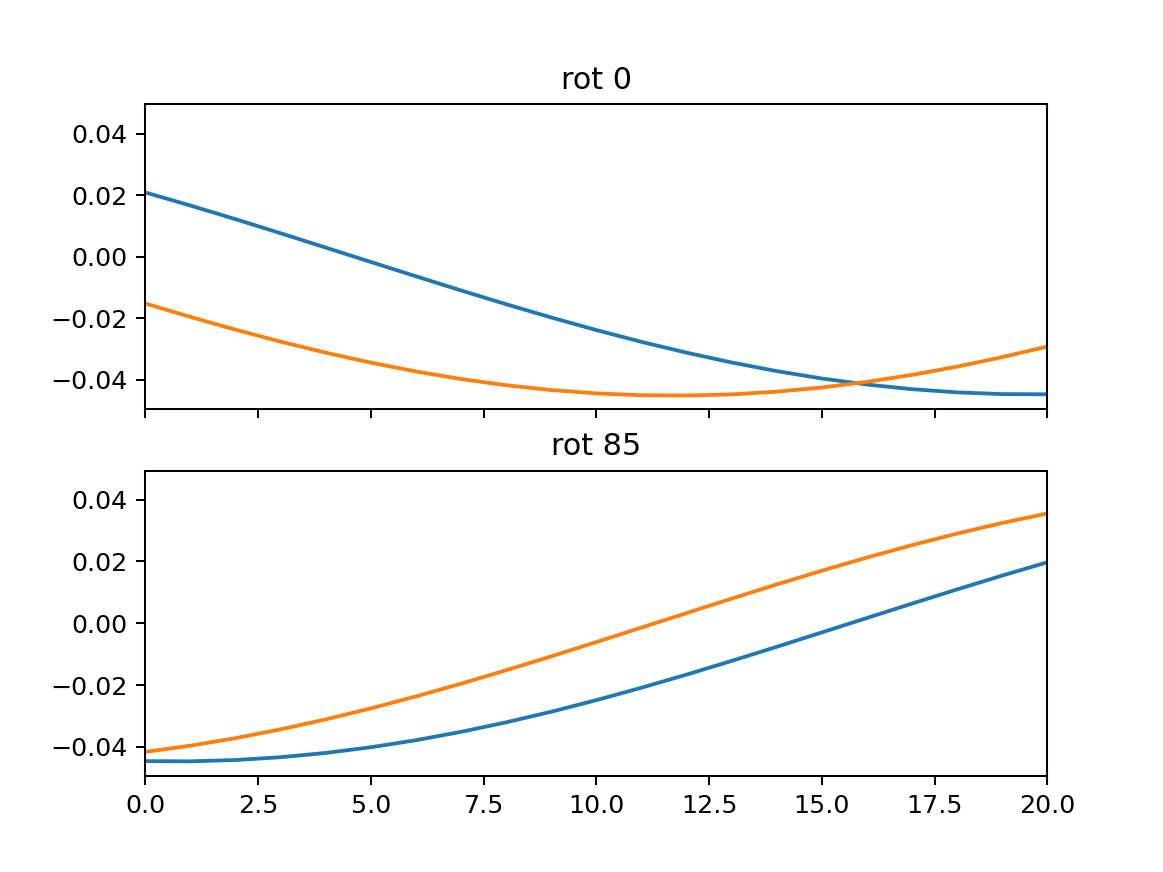

<IPython.core.display.Javascript object>


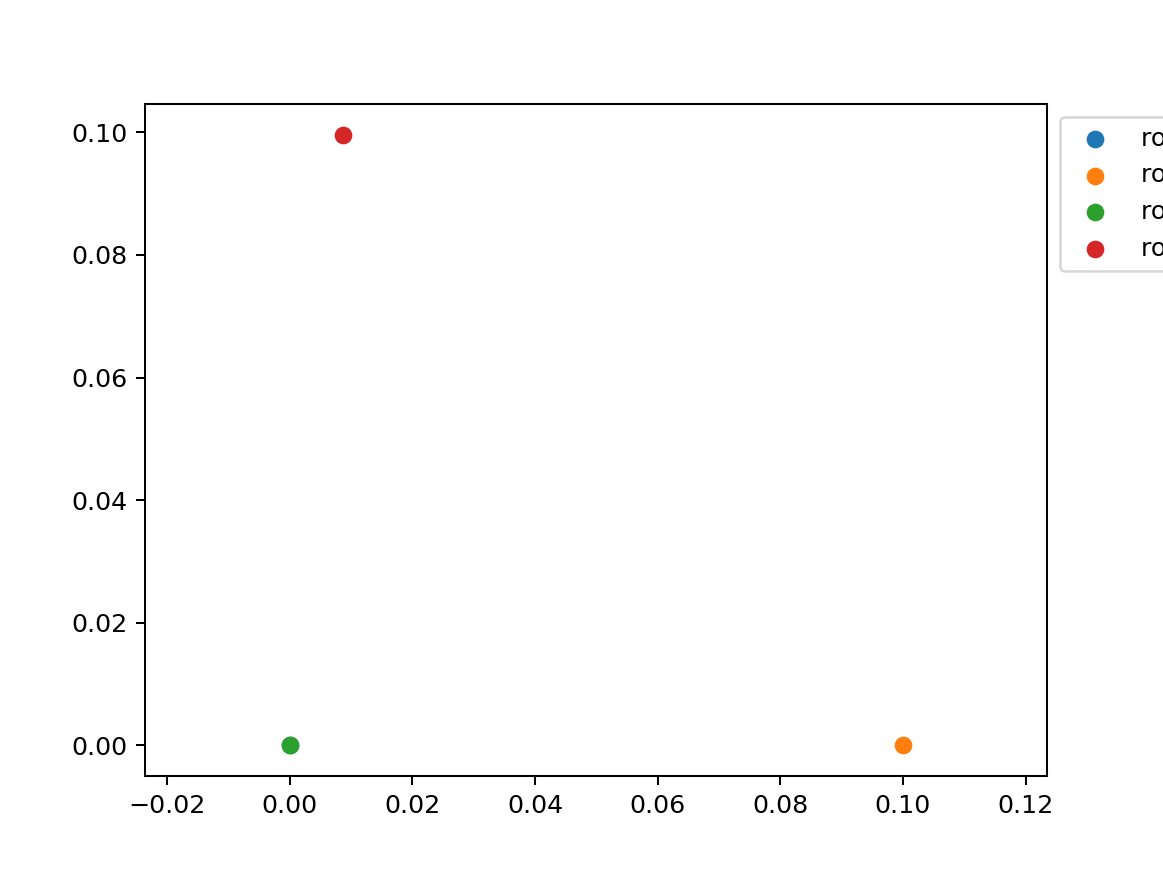

In [8]:
from itertools import cycle

fig, axs = plt.subplots(len(degrees), sharex=True)
colors = []
for j, (degree, buffer) in enumerate(zip(degrees, buffers)):
    axs[j].set_title(f'rot {degree}')
    for i in range(buffer.shape[0]): # n_mics
        color=f"C{i}"
        colors.append(color)
        axs[j].plot(range(buffer.shape[1]), buffer[i], label=f"mic{i}", color=color)
    axs[j].set_xlim(0, 20)

plt.figure()
for degree, mics in zip(degrees, mics_list):
    for j in range(mics.shape[0]):
        plt.scatter(*mics[j], label=f'rot {degree}, mic{j}')
#plt.scatter(*source.T, label='source')
plt.axis('equal')
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')
pass

# create "real" multi-mic array

mics shape: (4, 2)
0 30000 0
error: 0.0 0 0.0
shifted signals by 0 (4, 3000956)


<IPython.core.display.Javascript object>


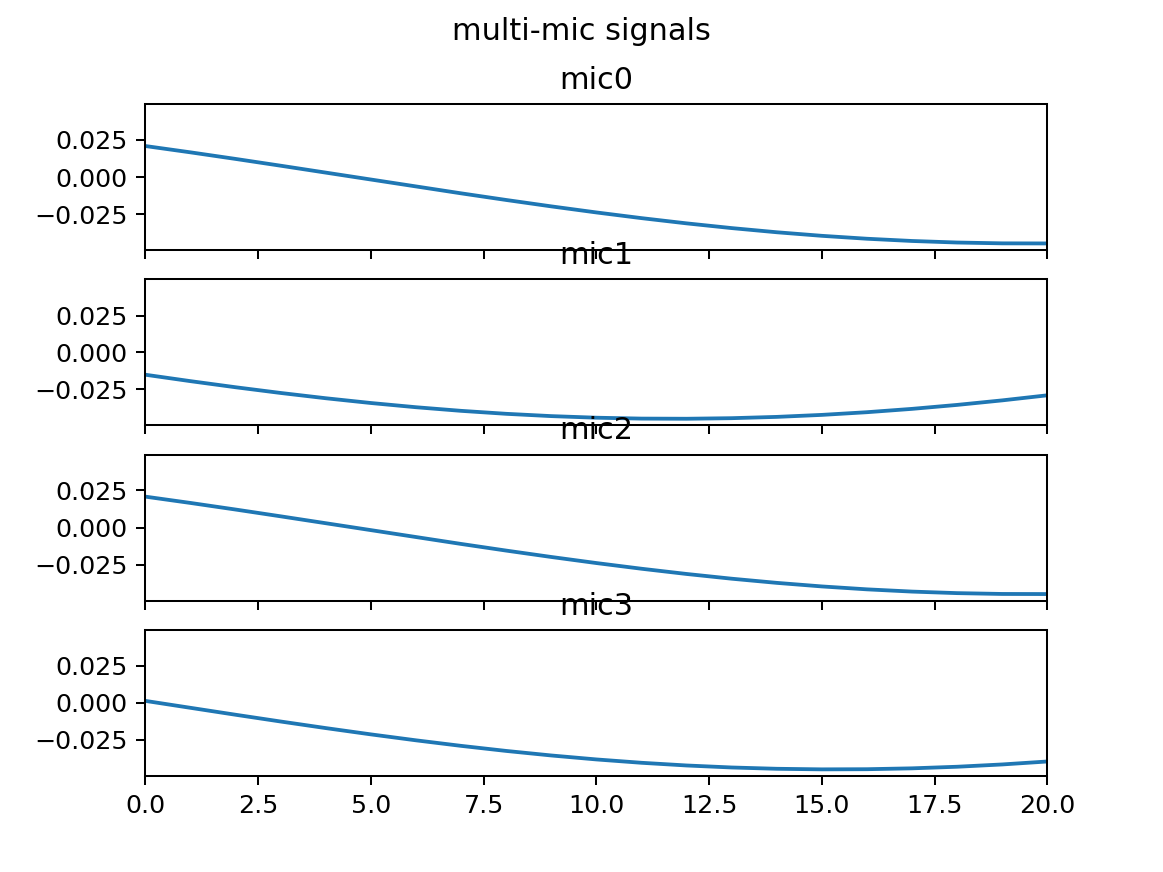

Text(0.5, 0.98, 'multi-mic signals')

In [9]:
mics_array = np.concatenate([*mics_list])
print('mics shape:', mics_array.shape)
signals_multimic = generate_signals(source_signal, mics_array.T, time=0)
buffer_multimic = signals_multimic[:, time_index:time_index + n_buffer]

fig, axs = plt.subplots(buffer_multimic.shape[0], sharex=True)
for i in range(buffer_multimic.shape[0]): # n_mics
    label=f"mic{i}"
    axs[i].plot(range(buffer_multimic.shape[1]), buffer_multimic[i], label=label)
    axs[i].set_title(label)
    axs[i].set_xlim(0, 20)
plt.suptitle('multi-mic signals')

<IPython.core.display.Javascript object>


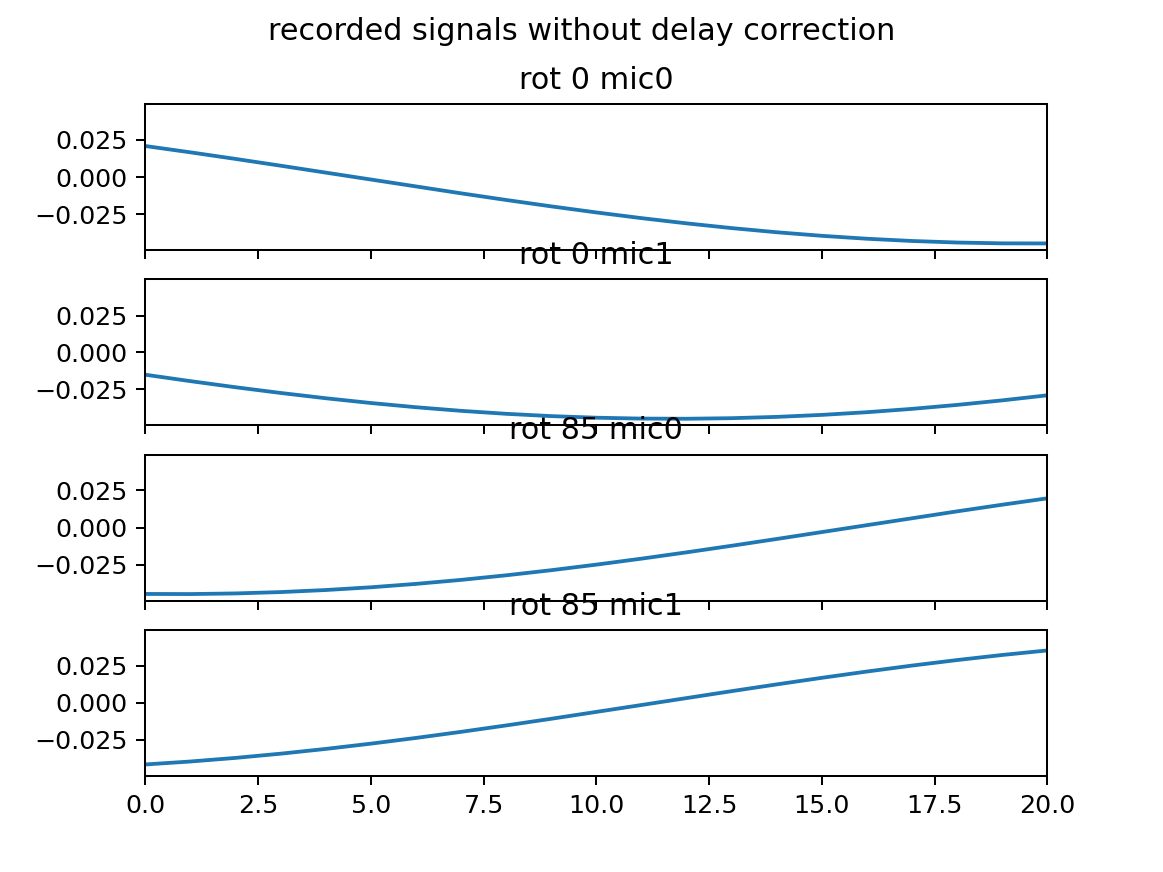

Text(0.5, 0.98, 'recorded signals without delay correction')

In [10]:
fig, axs = plt.subplots(buffer_multimic.shape[0], sharex=True)
counter = 0
for j, (degree, buffer) in enumerate(zip(degrees, buffers)):
    for i in range(buffer.shape[0]): # n_mics
        label = f"rot {degree} mic{i}"
        axs[counter].plot(range(buffer.shape[1]), buffer[i], label=label)
        axs[counter].set_title(label)
        axs[counter].set_xlim(0, 20)
        counter += 1
plt.suptitle('recorded signals without delay correction')

# "real" spectrum

selecting 1 bins
[[[ 0.         -0.82067038  0.         -0.45592749]
  [ 0.82067038  0.          0.82067038  0.36474289]
  [ 0.         -0.82067038  0.         -0.45592749]
  [ 0.45592749 -0.36474289  0.45592749  0.        ]]]


<IPython.core.display.Javascript object>


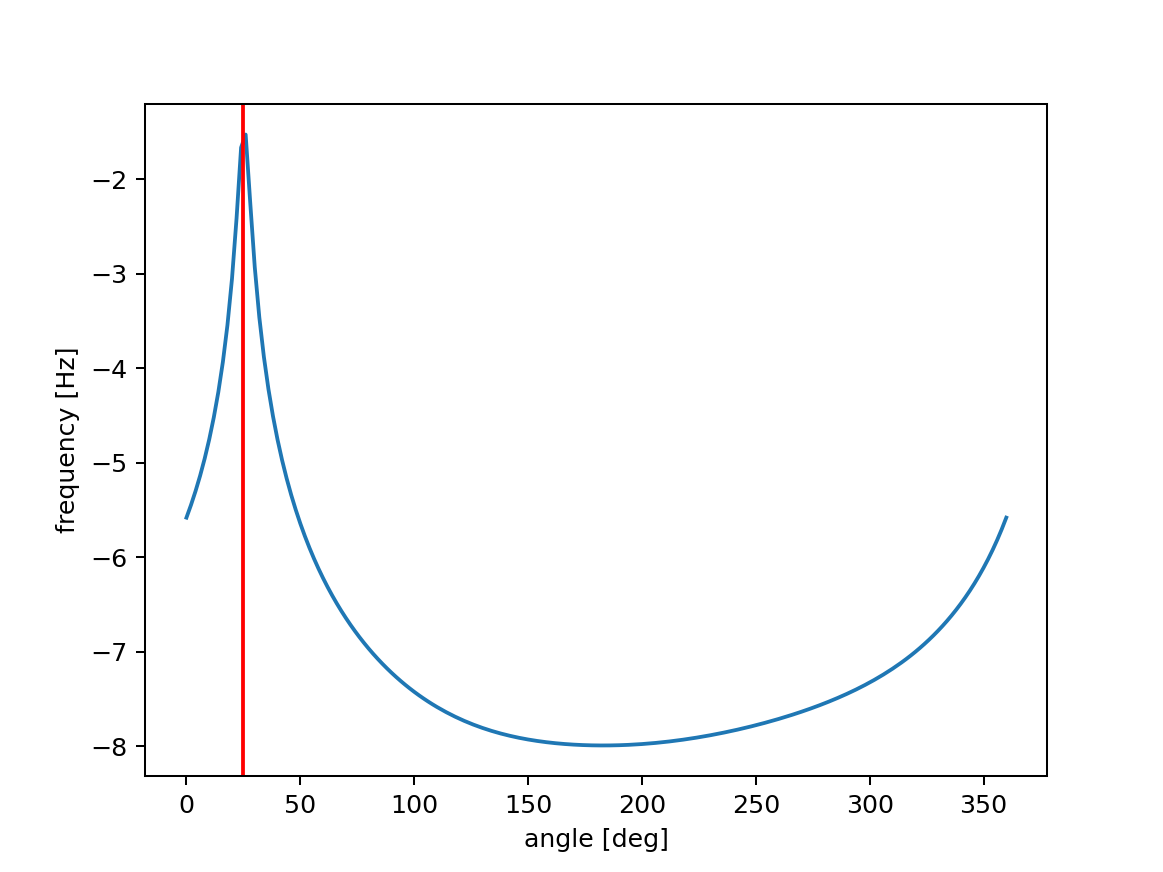

In [11]:
from audio_stack.beam_former import BeamFormer

beam_former = BeamFormer(mic_positions=mics_array)
angles = beam_former.theta_scan * 180 / np.pi

signals_f = np.fft.rfft(buffer_multimic).T
frequencies = np.fft.rfftfreq(n=n_buffer, d=1 / Fs)

indices = select_here()

signals_f = signals_f[indices, :]
frequencies = frequencies[indices]

R = beam_former.get_correlation(signals_f)
print(np.angle(R))
spectrum_multimic = beam_former.get_mvdr_spectrum(R, frequencies)
plot_spectrum(spectrum_multimic, degree=gt_angle_deg)

# combine spectra

In [12]:
beam_former = BeamFormer(mic_positions=mics_drone)

# calculate individual spectra for each pose
signals_f_list = [np.fft.rfft(buffer).T for buffer in buffers] # n_frequences x 4
signals_f_list = [sig_f[indices, :] for sig_f in signals_f_list]
    
Rs = [beam_former.get_correlation(sig_f) for sig_f in signals_f_list]
#spectra = [beam_former.get_das_spectrum(R, frequencies) for R in Rs]
spectra = [beam_former.get_mvdr_spectrum(R, frequencies) for R in Rs]

# combine the individual spectra, accounting for the orientation of the drone
combination_method = "sum"
normalization_method = "none"
#normalization_method = "sum_to_one"
#normalization_method = "zero_to_one"
#combination_method = "product"
beam_former.init_dynamic_estimate(combination_n=len(degrees), 
                                  combination_method=combination_method, 
                                  normalization_method=normalization_method)
for spectrum, degree in zip(spectra, degrees):
    beam_former.add_to_dynamic_estimates(spectrum, -degree)

combined_spectra = beam_former.get_dynamic_estimate()

<IPython.core.display.Javascript object>


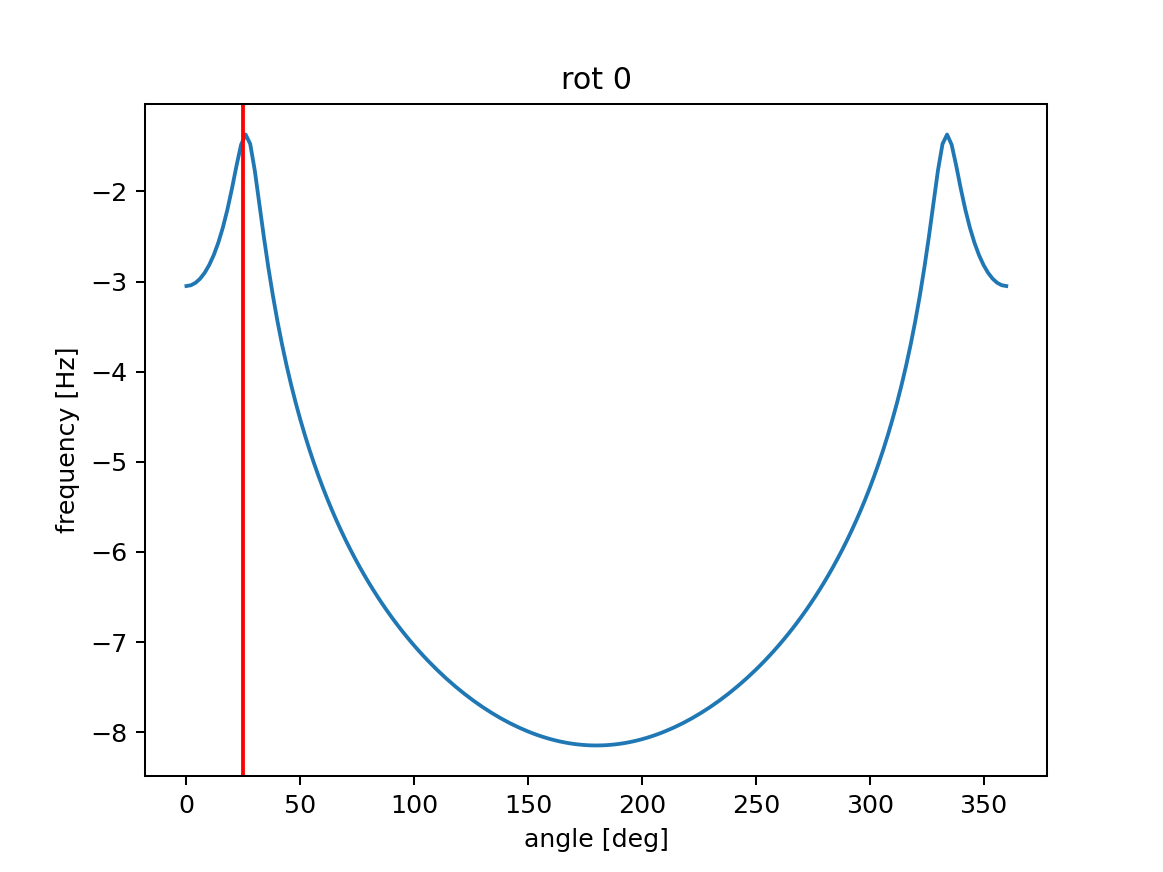

<IPython.core.display.Javascript object>


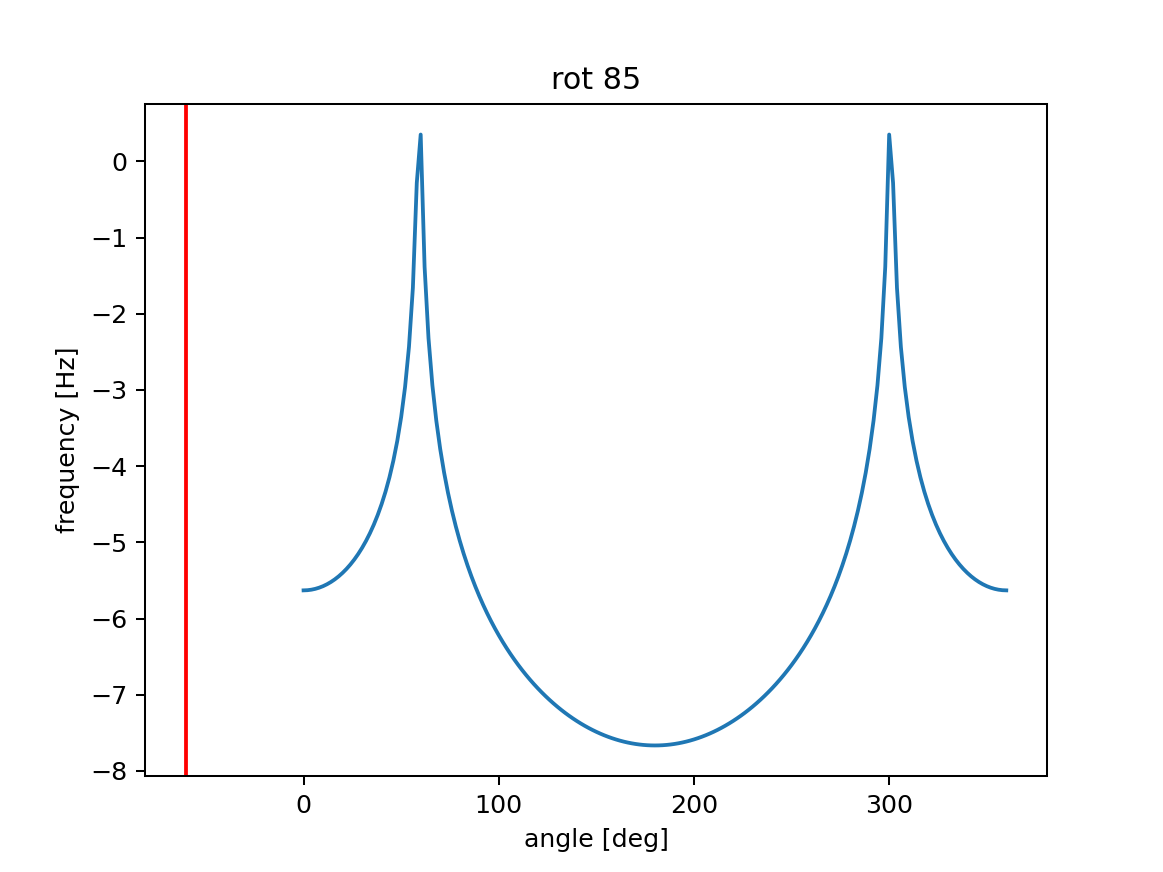

<IPython.core.display.Javascript object>


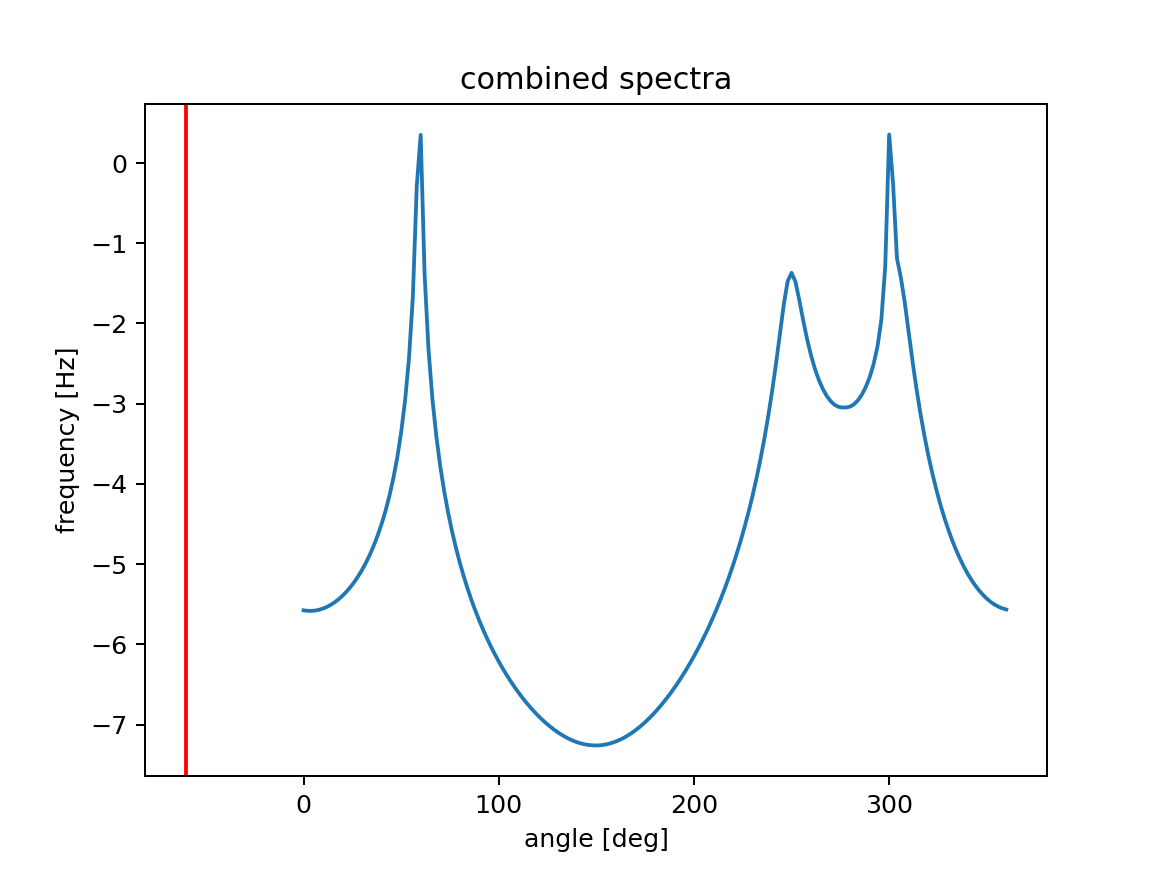

In [13]:
for spectrum, degree in zip(spectra, degrees):
    plot_spectrum(spectrum, gt_angle_deg - degree)
    plt.title(f'rot {degree}')

plot_spectrum(combined_spectra, gt_angle_deg - degrees[-1])
plt.title(f'combined spectra')
pass

In [14]:
# signals with delay correction

signals_f_list_delayed = []
for i, (sig_f, time) in enumerate(zip(signals_f_list, times_list)):
    # TODO(FD) figure out if this is correct
    exp_factor = np.exp(-1j * np.pi * frequencies * time)
    print('phase difference:', np.angle(exp_factor))
    signals_f_delayed = np.multiply(sig_f, exp_factor[:, np.newaxis])  # frequencies x n_mics
    signals_f_list_delayed.append(signals_f_delayed)
    
for sig_f, signals_f_delayed in zip(signals_f_list, signals_f_list_delayed):
    print('original:', np.angle(sig_f))
    print('corrected:', np.angle(signals_f_delayed))
    
print(signals_f.shape)
print('multi-mic:', np.angle(signals_f), np.angle(signals_f)[0, 1] - np.angle(signals_f)[0, 0])
print('multi-mic:', np.angle(signals_f), np.angle(signals_f)[0, 3] - np.angle(signals_f)[0, 2])

phase difference: [0.]
phase difference: [-1.71359599]
original: [[2.14807169 2.96874207]]
corrected: [[2.14807169 2.96874207]]
original: [[-2.18271841 -1.71613782]]
corrected: [[2.38687091 2.8534515 ]]
(1, 4)
multi-mic: [[2.14807169 2.96874207 2.14807169 2.60399918]] 0.8206703778011954
multi-mic: [[2.14807169 2.96874207 2.14807169 2.60399918]] 0.4559274891218412


# combine raw signals

phases, original [[2.14807169 2.96874207]]
phases, corrected [[2.14807169 2.96874207]]
phases, original [[-2.18271841 -1.71613782]]
phases, corrected [[2.38687091 2.8534515 ]]
[[[ 0.         -0.82067038 -0.23879921 -0.70537981]
  [ 0.82067038  0.          0.58187116  0.11529057]
  [ 0.23879921 -0.58187116  0.         -0.46658059]
  [ 0.70537981 -0.11529057  0.46658059  0.        ]]]


<IPython.core.display.Javascript object>


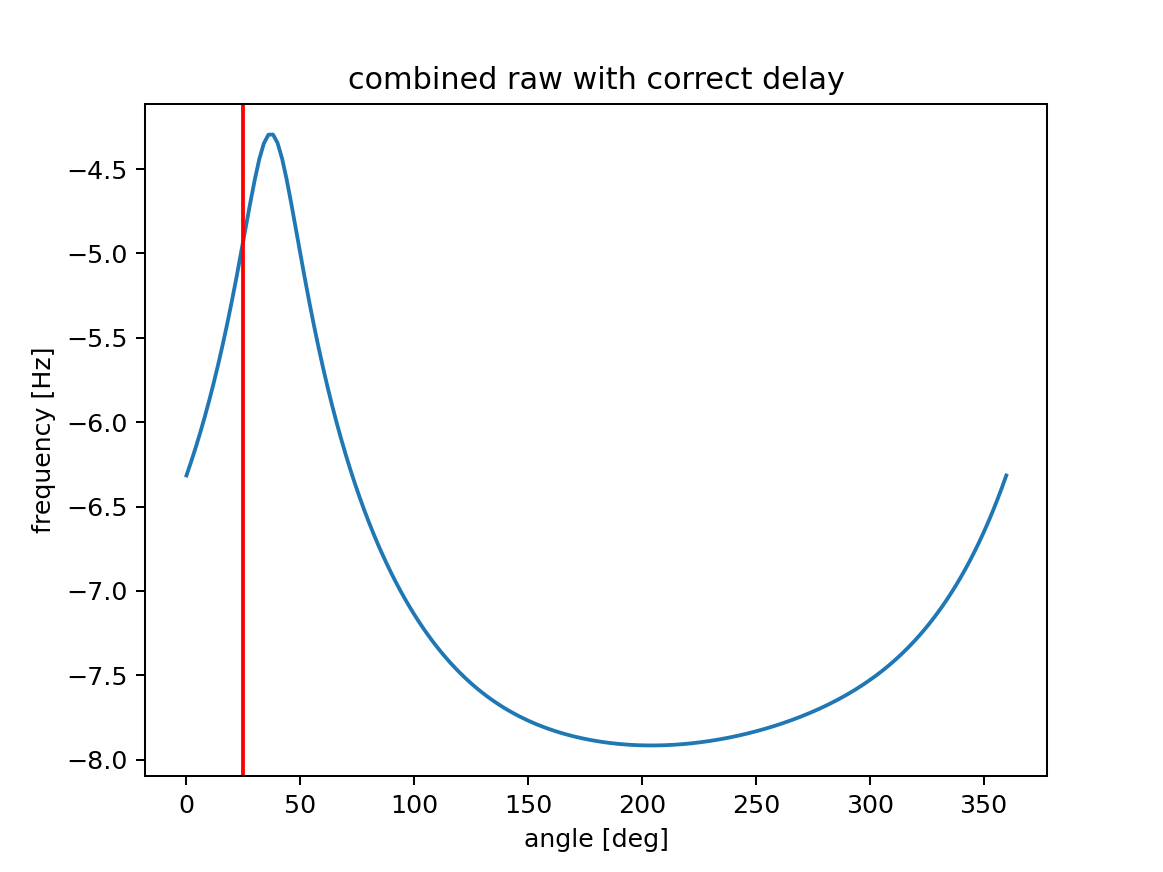

<IPython.core.display.Javascript object>


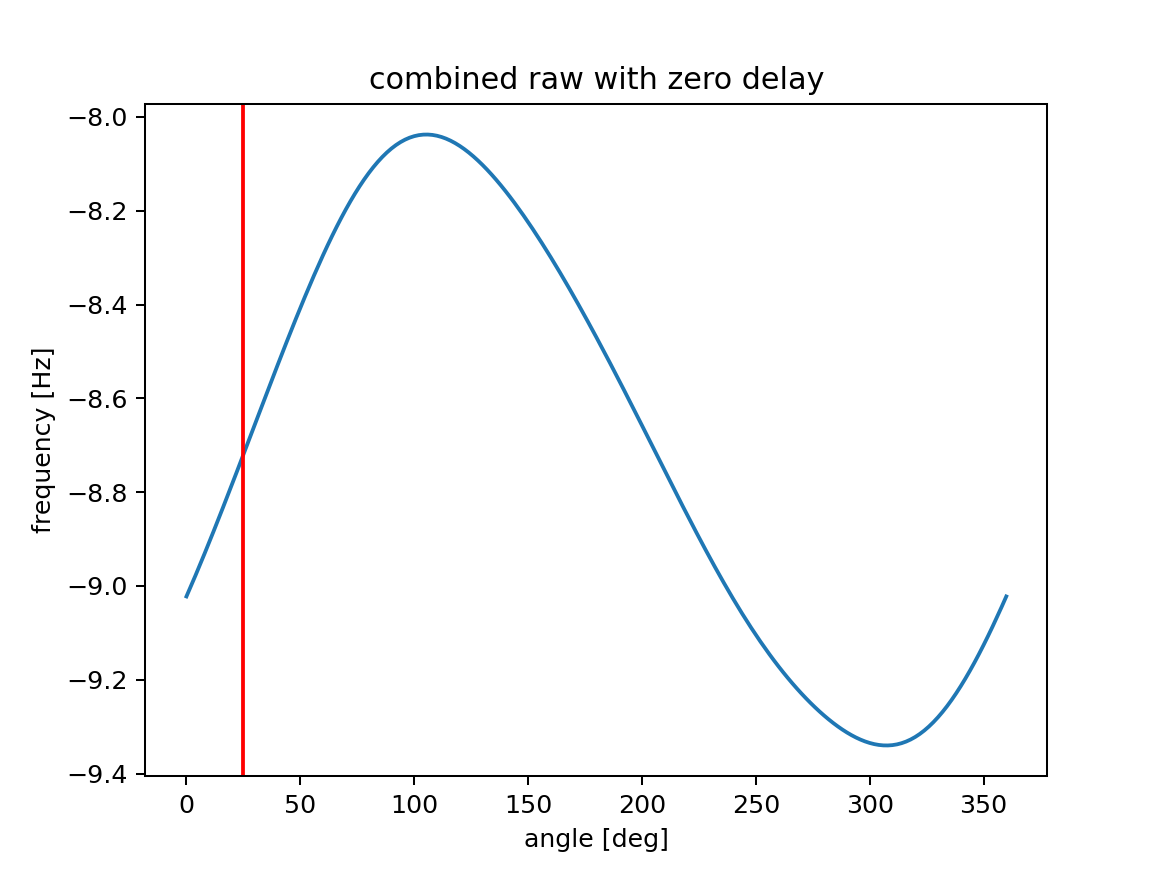

In [15]:
from algos_basics import get_mic_delays

beam_former = BeamFormer(mic_positions=mics_array)

signals_f_tot_delay = np.empty((len(frequencies), 0))
signals_f_tot_zero = np.empty((len(frequencies), 0))

for i, (sig_f, signals_f_delayed) in enumerate(zip(signals_f_list, signals_f_list_delayed)):
    signals_f_tot_delay = np.c_[signals_f_tot_delay, signals_f_delayed]
    # for testing purposes, we also look at the spectra without compensating
    # for the delays.
    signals_f_tot_zero = np.c_[signals_f_tot_zero, sig_f]
    
    print('phases, original', np.angle(sig_f))
    print('phases, corrected', np.angle(signals_f_delayed))

Rtot_zero = beam_former.get_correlation(signals_f_tot_zero)
combined_raw_zero = beam_former.get_mvdr_spectrum(Rtot_zero, frequencies)

Rtot_delay = beam_former.get_correlation(signals_f_tot_delay)
print(np.angle(Rtot_delay))
combined_raw_delay = beam_former.get_mvdr_spectrum(Rtot_delay, frequencies)

plot_spectrum(combined_raw_delay, degree=gt_angle_deg)
plt.title('combined raw with correct delay')

plot_spectrum(combined_raw_zero, degree=gt_angle_deg)
plt.title('combined raw with zero delay')
pass

# compare results

0


<IPython.core.display.Javascript object>


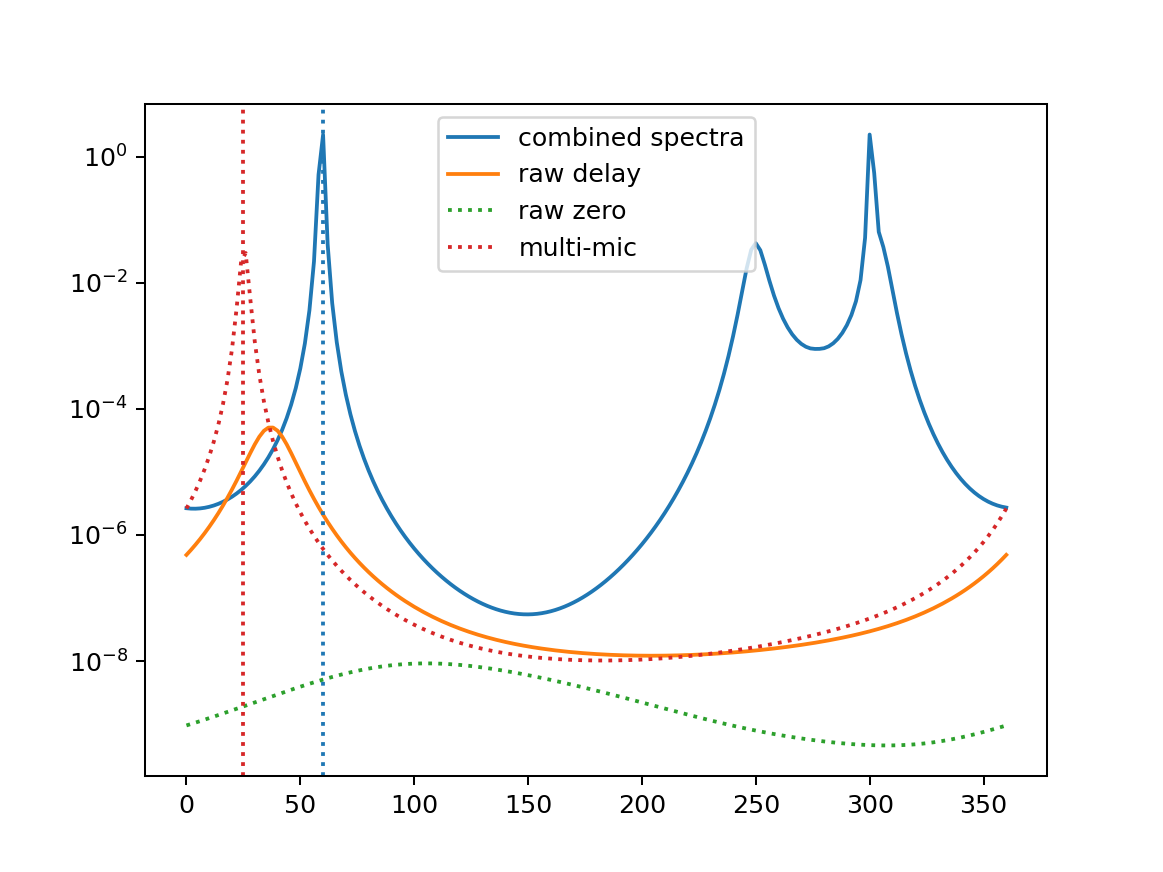

In [16]:
chosen_idx = np.argmin(np.abs(frequencies - frequency_hz))
print(chosen_idx)
plt.figure()
plt.semilogy(angles, combined_spectra[chosen_idx], label='combined spectra')
plt.semilogy(angles, combined_raw_delay[chosen_idx], label='raw delay')
plt.semilogy(angles, combined_raw_zero[chosen_idx], label='raw zero', ls=':')
plt.semilogy(angles, spectrum_multimic[chosen_idx], label='multi-mic', ls=':')
plt.axvline(gt_angle_deg, color='C3', ls=':')
plt.axvline(degrees[-1]-gt_angle_deg, color='C0', ls=':')
plt.legend()